In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import mobilenet_v3_small, mobilenet_v3_large
import torch.nn.functional as F

In [2]:
# Define transformations for the dataset (similar to Inception preprocessing)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [3]:
# Load ImageNet dataset
train_data_path = "./Dataset/imagenet_mini/imagenet-mini/train/"
test_data_path =  "./Dataset/imagenet_mini/imagenet-mini/val/"

train_dataset = ImageFolder(train_data_path, transform=transform)
test_dataset = ImageFolder(test_data_path, transform=transform)

In [4]:
# # Split dataset into training and validation sets
# train_size = int(0.8 * len(imagenet_dataset))
# val_size = len(imagenet_dataset) - train_size
# train_dataset, val_dataset = random_split(imagenet_dataset, [train_size, val_size])

In [5]:
# Define DataLoader for training and validation sets
batch_size = 150
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=14)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=14)

In [6]:
# Define MobileNetV3 model
model = mobilenet_v3_small(weights=None)
# model = mobilenet_v3_large(weights=None, )
num_classes = 1000  # Number of classes in ImageNet
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)

In [7]:
# Batch normalization with specified decay rate
def bn_momentum_change(model, momentum):
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.momentum = momentum

# Apply batch normalization with average decay of 0.99
bn_momentum_change(model, momentum=0.99)

In [8]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)

# Learning rate scheduler: decay by a factor of 0.01 every 3 epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.01)


In [9]:
# Training loop
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [10]:
train_losses = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    # print(f'Training Epoch: {1 + epoch}')
    # Training
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(test_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Learning rate scheduler step
    # lr_scheduler.step()
    
    # Print statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val Acc: {val_acc:.4f}, '
          f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

print('Finished Training')

Epoch [1/30], Train Loss: 7.5053, Val Loss: 7.5946, Val Acc: 0.0018, Learning Rate: 0.001000
Epoch [2/30], Train Loss: 7.1392, Val Loss: 7.1992, Val Acc: 0.0003, Learning Rate: 0.001000
Epoch [3/30], Train Loss: 7.0764, Val Loss: 7.3851, Val Acc: 0.0005, Learning Rate: 0.001000
Epoch [4/30], Train Loss: 6.9831, Val Loss: 7.0141, Val Acc: 0.0018, Learning Rate: 0.001000
Epoch [5/30], Train Loss: 6.9787, Val Loss: 6.9634, Val Acc: 0.0008, Learning Rate: 0.001000
Epoch [6/30], Train Loss: 6.9876, Val Loss: 6.9977, Val Acc: 0.0023, Learning Rate: 0.001000
Epoch [7/30], Train Loss: 7.0257, Val Loss: 6.9925, Val Acc: 0.0008, Learning Rate: 0.001000
Epoch [8/30], Train Loss: 6.9715, Val Loss: 7.0487, Val Acc: 0.0010, Learning Rate: 0.001000
Epoch [9/30], Train Loss: 6.9743, Val Loss: 7.0015, Val Acc: 0.0020, Learning Rate: 0.001000
Epoch [10/30], Train Loss: 6.9609, Val Loss: 6.9462, Val Acc: 0.0028, Learning Rate: 0.001000
Epoch [11/30], Train Loss: 6.8846, Val Loss: 6.9599, Val Acc: 0.0025,

In [11]:
import matplotlib.pyplot as plt

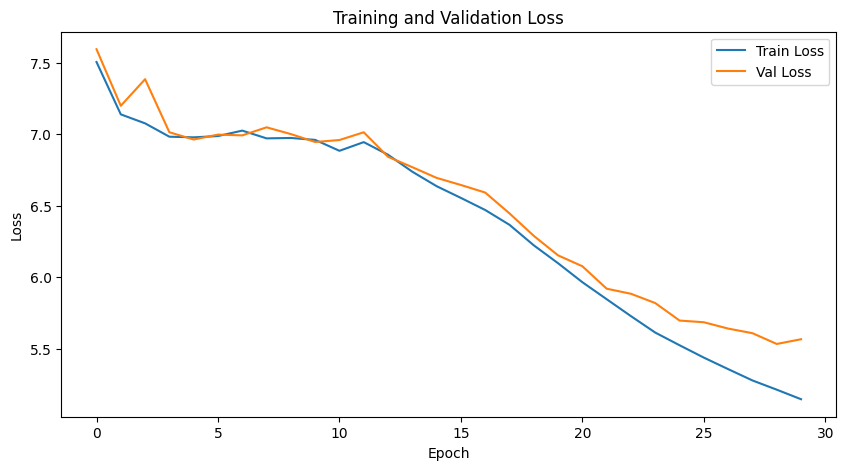

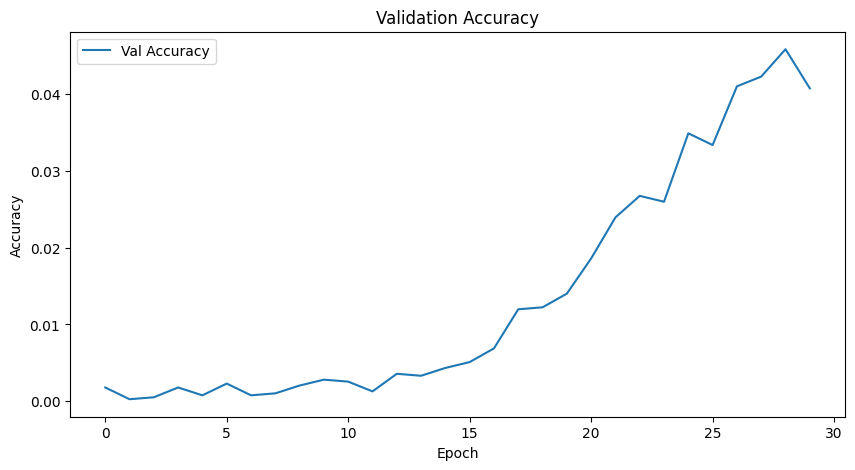

In [12]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()


In [13]:
# Save the entire model including architecture, parameters, and optimizer state
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accs': val_accs
}, 'mobilenet_v3_model.pth')